In [1]:
# PARAMETERS

# which game in the future are you trying to predict? shift_param=1 means the next game (2 means the one after that etc.)
shift_param = 1

In [2]:
# IMPORTS

import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import os

import catboost 
import shap
import optuna

from sklearn import linear_model
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Functions

In [3]:
def calculate_performance_metrics(y_true, y_predicted, plot=True):
    mae = mean_absolute_error(y_true, y_predicted)
    rmse = mean_squared_error(y_true, y_predicted, squared=False)
    r2 = r2_score(y_true, y_predicted)

    if plot:
        x0 = y_predicted
        y0 = y_true

        fig = px.scatter(x=x0, y=y0, marginal_x="histogram", marginal_y="histogram")
        fig.add_trace(
            go.Scatter(x=np.linspace(np.min(x0), np.max(x0), 100), 
                    y=np.linspace(np.min(x0), np.max(x0), 100),
                    showlegend=False,)
        )

        fig.show()

    return (mae, rmse, r2)


In [4]:
# DEFINE OPTUNA OBJECTIVE FOR HYPER-PARAMETER OPTIMIZATION
def optuna_objective(trial, model_name, params, optuna_params, X_train, y_train, folds, test_metric):
    '''
    Objective function for Optuna to optimize.

    Inputs:
        trial: Optuna trial object.
        model_name (str): String to specify which model type to optimize. Current options: {catboost}.
        params (dict): model parameters.
        optuna_params (dict): Optuna-specific parameters. 
        X_train (array-like): Training data inputs.
        Y_train (array-like): Training data target values.
        folds (sklearn KFold): Cross-validation folds.
        test_metric (str): Chosen metric for evaluating model performance in the test set.

    Output:
        best_result (float): Mean of the test-metric across cross-validation folds.
    '''

    if model_name=='catboost':   
        
        if 'cat_learning_rate_bounds' in optuna_params.keys():
            params['learning_rate'] = trial.suggest_float('learning_rate', 
                                                    optuna_params['cat_learning_rate_bounds'][0],
                                                    optuna_params['cat_learning_rate_bounds'][1],
                                                    )
        
        if 'cat_depth_bounds' in optuna_params.keys():
            params['depth'] = trial.suggest_int('depth', optuna_params['cat_depth_bounds'][0], 
                                                optuna_params['cat_depth_bounds'][1])
        
        if 'cat_objective_list' in optuna_params.keys():
            params['objective'] = trial.suggest_categorical('objective', optuna_params['cat_objective_list'])

        if 'l2_leaf_reg_bounds'in optuna_params.keys():
            params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 
                                                    optuna_params['l2_leaf_reg_bounds'][0],
                                                    optuna_params['l2_leaf_reg_bounds'][1],
                                                    log=optuna_params['l2_leaf_reg_bounds'][2],)
        
        if 'random_strength_bounds'in optuna_params.keys():
            params['random_strength'] = trial.suggest_float('random_strength', 
                                                    optuna_params['random_strength_bounds'][0],
                                                    optuna_params['random_strength_bounds'][1],
                                                    log=optuna_params['random_strength_bounds'][2])
            
        if 'subsample_bounds' in optuna_params.keys():
            params['subsample'] = trial.suggest_float('subsample', optuna_params['subsample_bounds'][0], 
                                                optuna_params['subsample_bounds'][1])
            
        if 'colsample_bylevel_bounds' in optuna_params.keys():
            params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', optuna_params['colsample_bylevel_bounds'][0], 
                                                optuna_params['colsample_bylevel_bounds'][1])
        
        if 'min_data_in_leaf_bounds' in optuna_params.keys():
            params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', optuna_params['min_data_in_leaf_bounds'][0], 
                                                optuna_params['min_data_in_leaf_bounds'][1])

        params['eval_metric'] = test_metric
        
        cv_data = catboost.Pool(
            data=X_train,
            label=y_train,
            cat_features = params['cat_features'] if 'cat_features' in params.keys() else None,
        )

        cv_df = catboost.cv(
            pool=cv_data,
            params=params,
            folds=folds,
            num_boost_round=1000, 
            early_stopping_rounds=50, 
            #verbose_eval=False,
            logging_level='Silent',
            shuffle=False,
        )
        
        best_result = cv_df.sort_values(f'test-{test_metric}-mean')[f'test-{test_metric}-mean'].iloc[0]        

    else:
        print('Incorrect model name!')
        return
    
    return best_result

In [5]:
def cat_optuna(X_train, y_train, X_test, y_test, model_params, cat_optuna_params, 
               best_params, metrics, folds, test_metric, n_optimization_trials=100):
    '''
    Performs hyperparameter optimization for the CatBoost regressor using Optuna.

    Input:
        X_train (array-like): The training input samples.
        Y_train (array-like): The target values for the training set.
        X_test (array-like): The test input samples.
        Y_test (array-like): The target values for the test set.
        model_params (dict): model parameters.
        cat_optuna_params (dict): Parameters for Optuna optimization.
        best_params (dict): A dictionary to store the best hyperparameters found during optimization.
        metrics (dict): A dictionary for saving model performance results.
        model_spec (dict): A dictionary defining inputs, the target and the training and test periods.
        n_optimization_trials (int): Number of optimization trials to be performed with Optuna.
        
    Output:
        metrics (dict): A dictionary for saving model performance results.
        best_params (dict): A dictionary to store the best hyperparameters found during optimization.
    '''

    study = optuna.create_study() 
    study.optimize(lambda trial: optuna_objective(trial, 
                                                model_name = 'catboost',
                                                params=model_params, 
                                                optuna_params = cat_optuna_params,
                                                X_train = X_train,
                                                y_train = y_train, 
                                                folds = folds, 
                                                test_metric = test_metric,
                                                ), 
                    n_trials=n_optimization_trials,)
    
    print('Best params:')
    print(study.best_params)
    print(f'Training {test_metric} for best params:')
    print(study.best_value)

    # Visualize optimization run
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    # Redo cross-validation with best params to get the optimal n_estimators
    cv_data = catboost.Pool(
            data=X_train,
            label=y_train,
            cat_features = model_params['cat_features'] if 'cat_features' in model_params.keys() else None,
        )
    
    #cat_params={}
    cat_params = model_params
    cat_params['learning_rate'] = study.best_params['learning_rate']
    cat_params['depth'] = study.best_params['depth']
    cat_params['objective'] = study.best_params['objective']
    cat_params['eval_metric'] = test_metric

    cv_df = catboost.cv(
            pool=cv_data,
            params=cat_params,
            folds=folds,
            num_boost_round=1000, 
            early_stopping_rounds=50, 
            #verbose_eval=False,
            logging_level='Silent',
            shuffle=False,
        ) 
    nr_iterations = cv_df.sort_values(f'test-{test_metric}-mean')['iterations'].iloc[0] + 1

    # train best catboost model with whole training data
    cat_model = catboost.CatBoostRegressor(iterations=nr_iterations, verbose=False, **cat_params)
    cat_model.fit(X_train, y_train)

    # test predictions
    y_predicted = pd.Series(
        cat_model.predict(X_test),
        index=X_test.index
    )

    print('CATBOOST')
    metrics["test"] = calculate_performance_metrics(y_test.values.flatten(), y_predicted.values.flatten())
    best_params["catboost"] = study.best_params
    best_params["catboost"]['nr_estimators'] = nr_iterations
    
    explainer = shap.Explainer(cat_model)
    shap_values = explainer(X_train);
    shap.plots.beeswarm(shap_values, max_display=15)
    
    print()

    return metrics, best_params, cat_model, shap_values, study

# Data processing

In [6]:
# fetch data
filepath = Path('../../data/modeling/fpl_df.csv')
df = pd.read_csv(filepath, index_col=0)
display(df.head())
display(df.shape)

assists  bonus  bps  clean_sheets  corners_and_indirect_freekicks_order  \
0        0      0    3             0                                   NaN   
1        1      0   39             1                                   NaN   
2        0      2   58             1                                   NaN   
3        0      1   47             1                                   NaN   
4        0      0   21             1                                   NaN   

   creativity  creativity_rank  creativity_rank_type  direct_freekicks_order  \
0         0.0              493                   188                     4.0   
1        51.7               19                    15                     6.0   
2        18.4               95                    11                     5.0   
3         0.0              460                    47                     NaN   
4        23.9               74                    49                     2.0   

   dreamteam_count  element_type  event_points      first_name  \
0                0             2             1           David   
1                0             3             5  Pierre-Emerick   
2                0             4             7       Alexandre   
3                0             1             2           Bernd   
4                0             3             2          Granit   

   goals_conceded  goals_scored  ict_index  ict_index_rank  \
0               0             0        0.0             497   
1               1             1       18.5              13   
2               1             2       16.9              20   
3               1             0        3.2             191   
4               1             0        6.8              88   

   ict_index_rank_type  influence  influence_rank  influence_rank_type  \
0                  188        0.0             490                  188   
1                    9       64.6              31                   15   
2                    8       71.6              25                    9   
3                   12       32.0             100                   12   
4                   44       23.2             133                   47   

   minutes  now_cost  own_goals  penalties_missed  penalties_order  \
0        1        55          0                 0              NaN   
1      180       119          0                 0              1.0   
2      162        85          0                 0              3.0   
3      180        50          0                 0              NaN   
4      167        55          0                 0              NaN   

   penalties_saved  points_per_game  red_cards  saves           second_name  \
0                0              1.0          0      0  Luiz Moreira Marinho   
1                0              6.0          0      0            Aubameyang   
2                0              7.0          0      0             Lacazette   
3                0              4.5          0      4                  Leno   
4                0              2.5          0      0                 Xhaka   

   selected_by_percent  threat  threat_rank  threat_rank_type  total_points  \
0                  0.9     0.0          479               186             1   
1                 32.9    69.0           16                 6            12   
2                  5.1    79.0           14                10            14   
3                  9.0     0.0          435                47             9   
4                  0.8    21.0           92                49             5   

     web_name  yellow_cards team_name  gameweek season  gameweek_xG  \
0  David Luiz             0   Arsenal         2  20-21          0.0   
1  Aubameyang             1   Arsenal         2  20-21          0.1   
2   Lacazette             0   Arsenal         2  20-21          0.1   
3        Leno             0   Arsenal         2  20-21          0.0   
4       Xhaka             0   Arsenal         2  20-21          0.0   

   gameweek_xA  gameweek_xGA  gameweek_m

(21223, 157)

In [7]:
features_no_shift = ['element_type', 'home', 'opponent_xG_ewm_5', 'opponent_xG_ewm_10',
       'opponent_xG_ewm_20', 'opponent_xG_ewm_40', 'opponent_xGA_ewm_5',
       'opponent_xGA_ewm_10', 'opponent_xGA_ewm_20',
       'opponent_xGA_ewm_40', ]

features_shift = ['corners_and_indirect_freekicks_order', 'creativity_rank', 
       'direct_freekicks_order', 'ict_index_rank', 'influence_rank',
       'minutes', 'now_cost', 'penalties_order', 'points_per_game', 
       'selected_by_percent', 'threat_rank',
       'team_xG_ewm_5', 'team_xG_ewm_10', 'team_xG_ewm_20',
       'team_xG_ewm_40', 'team_xGA_ewm_5', 'team_xGA_ewm_10',
       'team_xGA_ewm_20', 'team_xGA_ewm_40', 
       'gameweek_assists_ewm_5', 'gameweek_bps_ewm_5',
       'gameweek_creativity_ewm_5', 'event_points_ewm_5',
       'gameweek_goals_scored_ewm_5', 'gameweek_goals_conceded_ewm_5',
       'gameweek_saves_ewm_5', 'gameweek_threat_ewm_5',
       'gameweek_xG_ewm_5', 'gameweek_xA_ewm_5', 'gameweek_xGA_ewm_5',
       'gameweek_minutes_ewm_5', 'gameweek_xPoints_ewm_5',
       'gameweek_assists_ewm_10', 'gameweek_bps_ewm_10',
       'gameweek_creativity_ewm_10', 'event_points_ewm_10',
       'gameweek_goals_scored_ewm_10', 'gameweek_goals_conceded_ewm_10',
       'gameweek_saves_ewm_10', 'gameweek_threat_ewm_10',
       'gameweek_xG_ewm_10', 'gameweek_xA_ewm_10', 'gameweek_xGA_ewm_10',
       'gameweek_minutes_ewm_10', 'gameweek_xPoints_ewm_10',
       'gameweek_assists_ewm_20', 'gameweek_bps_ewm_20',
       'gameweek_creativity_ewm_20', 'event_points_ewm_20',
       'gameweek_goals_scored_ewm_20', 'gameweek_goals_conceded_ewm_20',
       'gameweek_saves_ewm_20', 'gameweek_threat_ewm_20',
       'gameweek_xG_ewm_20', 'gameweek_xA_ewm_20', 'gameweek_xGA_ewm_20',
       'gameweek_minutes_ewm_20', 'gameweek_xPoints_ewm_20',
       'gameweek_assists_ewm_40', 'gameweek_bps_ewm_40',
       'gameweek_creativity_ewm_40', 'event_points_ewm_40',
       'gameweek_goals_scored_ewm_40', 'gameweek_goals_conceded_ewm_40',
       'gameweek_saves_ewm_40', 'gameweek_threat_ewm_40',
       'gameweek_xG_ewm_40', 'gameweek_xA_ewm_40', 'gameweek_xGA_ewm_40',
       'gameweek_minutes_ewm_40', 'gameweek_xPoints_ewm_40',
       'gameweek_assists_expanding', 'gameweek_bps_expanding',
       'gameweek_creativity_expanding', 'event_points_expanding',
       'gameweek_goals_scored_expanding',
       'gameweek_goals_conceded_expanding', 'gameweek_saves_expanding',
       'gameweek_threat_expanding', 'gameweek_xG_expanding',
       'gameweek_xA_expanding', 'gameweek_xGA_expanding',
       'gameweek_minutes_expanding', 'gameweek_xPoints_expanding',
       'gameweek_assists_expanding_per90', 'gameweek_bps_expanding_per90',
       'gameweek_creativity_expanding_per90',
       'event_points_expanding_per90',
       'gameweek_goals_scored_expanding_per90',
       'gameweek_goals_conceded_expanding_per90',
       'gameweek_saves_expanding_per90',
       'gameweek_threat_expanding_per90', 'gameweek_xG_expanding_per90',
       'gameweek_xA_expanding_per90', 'gameweek_xGA_expanding_per90',
       'gameweek_xPoints_expanding_per90', 'xG_overperformance'
    ]

target = ['event_points']

In [8]:
# shift give features
df[features_shift] = df.groupby('web_name')[features_shift].shift(shift_param)
display(df.head())
display(df.tail())
display(df.shape)

assists  bonus  bps  clean_sheets  corners_and_indirect_freekicks_order  \
0        0      0    3             0                                   NaN   
1        1      0   39             1                                   NaN   
2        0      2   58             1                                   NaN   
3        0      1   47             1                                   NaN   
4        0      0   21             1                                   NaN   

   creativity  creativity_rank  creativity_rank_type  direct_freekicks_order  \
0         0.0              NaN                   188                     NaN   
1        51.7              NaN                    15                     NaN   
2        18.4              NaN                    11                     NaN   
3         0.0              NaN                    47                     NaN   
4        23.9              NaN                    49                     NaN   

   dreamteam_count  element_type  event_points      first_name  \
0                0             2             1           David   
1                0             3             5  Pierre-Emerick   
2                0             4             7       Alexandre   
3                0             1             2           Bernd   
4                0             3             2          Granit   

   goals_conceded  goals_scored  ict_index  ict_index_rank  \
0               0             0        0.0             NaN   
1               1             1       18.5             NaN   
2               1             2       16.9             NaN   
3               1             0        3.2             NaN   
4               1             0        6.8             NaN   

   ict_index_rank_type  influence  influence_rank  influence_rank_type  \
0                  188        0.0             NaN                  188   
1                    9       64.6             NaN                   15   
2                    8       71.6             NaN                    9   
3                   12       32.0             NaN                   12   
4                   44       23.2             NaN                   47   

   minutes  now_cost  own_goals  penalties_missed  penalties_order  \
0      NaN       NaN          0                 0              NaN   
1      NaN       NaN          0                 0              NaN   
2      NaN       NaN          0                 0              NaN   
3      NaN       NaN          0                 0              NaN   
4      NaN       NaN          0                 0              NaN   

   penalties_saved  points_per_game  red_cards  saves           second_name  \
0                0              NaN          0      0  Luiz Moreira Marinho   
1                0              NaN          0      0            Aubameyang   
2                0              NaN          0      0             Lacazette   
3                0              NaN          0      4                  Leno   
4                0              NaN          0      0                 Xhaka   

   selected_by_percent  threat  threat_rank  threat_rank_type  total_points  \
0                  NaN     0.0          NaN               186             1   
1                  NaN    69.0          NaN                 6            12   
2                  NaN    79.0          NaN                10            14   
3                  NaN     0.0          NaN                47             9   
4                  NaN    21.0          NaN                49             5   

     web_name  yellow_cards team_name  gameweek season  gameweek_xG  \
0  David Luiz             0   Arsenal         2  20-21          0.0   
1  Aubameyang             1   Arsenal         2  20-21          0.1   
2   Lacazette             0   Arsenal         2  20-21          0.1   
3        Leno             0   Arsenal         2  20-21          0.0   
4       Xhaka             0   Arsenal         2  20-21          0.0   

   gameweek_xA  gameweek_xGA  gameweek_m

assists  bonus  bps  clean_sheets  \
21218        1      3  239             3   
21219        0      0   17             0   
21220        1      5  338            11   
21221        1      0  196             5   
21222        0      2   84             2   

       corners_and_indirect_freekicks_order  creativity  creativity_rank  \
21218                                   5.0       269.2            134.0   
21219                                   NaN        17.4            350.0   
21220                                   6.0       406.6             81.0   
21221                                   NaN        66.3            346.0   
21222                                   NaN        74.3            331.0   

       creativity_rank_type  direct_freekicks_order  dreamteam_count  \
21218                    26                     NaN                0   
21219                   213                     NaN                0   
21220                    66                     NaN                0   
21221                   179                     NaN                0   
21222                   174                     NaN                0   

       element_type  event_points    first_name  goals_conceded  goals_scored  \
21218             2             0          Hugo              29             0   
21219             3             1        Joseph               5             0   
21220             3             1  Matheus Luiz              38             1   
21221             3             2         Mario              28             0   
21222             3             2   João Victor              18             1   

       ict_index  ict_index_rank  ict_index_rank_type  influence  \
21218       57.2           254.0                   86      224.0   
21219        6.1           387.0                  213       14.4   
21220      109.3           111.0                   74      371.4   
21221       31.8           365.0                  162      216.4   
21222       25.8           388.0                  173      139.8   

       influence_rank  influence_rank_type  minutes  now_cost  own_goals  \
21218           278.0                  115   1262.0      38.0          0   
21219           402.0                  215    167.0      44.0          0   
21220           191.0                   80   2422.0      48.0          0   
21221           305.0                  124   1207.0      45.0          0   
21222           358.0                  146    565.0      45.0          0   

       penalties_missed  penalties_order  penalties_saved  points_per_game  \
21218                 0              NaN                0              2.0   
21219                 0              NaN                0              0.8   
21220                 0              NaN                0              2.5   
21221                 0              NaN                0              1.8   
21222                 0              NaN                0              1.9   

       red_cards  saves     second_name  selected_by_percent  threat  \
21218          0      0     Bueno López                  3.6    76.0   
21219          0      0           Hodge                  0.0    30.0   
21220          1      0           Nunes                  0.2   314.0   
21221          1      0          Lemina                  0.0    36.0   
21222          0      0  Gomes da Silva                  0.0    46.0   

       threat_rank  threat_rank_type  total_points    web_name  yellow_cards  \
21218        306.0               101            41       Bueno             1   
21219        320.0               193             5       Hodge             1   
21220        118.0                75            80     Matheus             2   
21221        385.0               189            35      Lemina             2   
21222        366.0               180            21  João Gomes             5   

      team_name  gameweek season  gameweek_xG  gameweek_xA  gameweek_xGA  \
21218    Wolves        38  22-23        

(21223, 157)

In [9]:
df[df.web_name=='Kane']

assists  bonus   bps  clean_sheets  \
173          4      3    88             0   
420          5      3    95             0   
675          6      6   159             0   
927          7      9   228             0   
1184         8      9   245             1   
1439         8      9   263             1   
1684         8     12   303             2   
1939         9     12   316             3   
2189         9     12   319             4   
2415        10     15   358             5   
2665        10     18   388             5   
2910        10     18   388             5   
3164        10     18   395             5   
3416        10     18   397             5   
3837        11     21   444             6   
4017        11     23   472             6   
4113        11     26   513             6   
4339        11     26   512             6   
5084        11     28   540             7   
5285        11     28   542             7   
5504        11     28   548             7   
5808        13     31   658             9   
6050        13     31   664             9   
6176        13     32   689            10   
6406        13     35   739            10   
6658        13     35   739            10   
7305        13     37   805            11   
7441        13     37   814            11   
7634        13     39   843            12   
7880        13     39   845            12   
8130        14     40   880            12   
8632         0      0    -3             0   
8890         0      0    -1             1   
9150         0      0     7             1   
9411         0      0    13             1   
9666         0      0     7             1   
9923         0      0     7             1   
10181        1      3    49             1   
10443        1      3    54             1   
10706        1      3    56             1   
10965        1      3    67             2   
11227        1      3    65             2   
11713        1      3    79             3   
11969        1      3    78             4   
12510        1      4    99             4   
12688        1      4   129             5   
12854        1      4   153             5   
13055        1      4   157             6   
13218        2      6   194             6   
13461        2      6   199             6   
13676        2      6   202             6   
13881        2      6   209             6   
14240        3     11   317             7   
14415        3     14   370             8   
14682        6     18   461             9   
14906        7     18   479             9   
15162       10     18   512            10   
15303       10     18   523            10   
15517       10     18   526            11   
15770       10     18   548            11   
16047       10     22   642            13   
16297       11     23   684            14   
16632        4     25   484             6   
17126        5     25   527             7   
17379        5     27   554             8   
17628        5     27   558             8   
17913        6     27   573             9   
18093        6     27   600            10   
18351        6     27   605            10   
18574        6     30   661            10   
18779        6     30   688            10   
18890        6     32   710            10   
19156        6     35   746            10   
19438        6     35   746            10   
19663        6     35   775            10   
19946        8     38   821            10   
20152        8     40   852            10   
20427        8     42   885            11   
20681        8     44   909            11   
20902        8     45   943            11   
21180        9     48  1008            11   

       corners_and_indirect_freekicks_order  creativity  creativity_rank  \
173                                     NaN        63.3              NaN   
420                                     NaN        86.8             10.0   
675                                     NaN       119.0             16.0   
927         

In [10]:
df.isnull().sum() / df.shape[0]

assists                                    0.000000
bonus                                      0.000000
bps                                        0.000000
clean_sheets                               0.000000
corners_and_indirect_freekicks_order       0.774443
creativity                                 0.000000
creativity_rank                            0.040758
creativity_rank_type                       0.000000
direct_freekicks_order                     0.795882
dreamteam_count                            0.000000
element_type                               0.000000
event_points                               0.000000
first_name                                 0.000000
goals_conceded                             0.000000
goals_scored                               0.000000
ict_index                                  0.000000
ict_index_rank                             0.040758
ict_index_rank_type                        0.000000
influence                                  0.000000
influence_ra

In [11]:
(df.isnull().sum(axis=1) > 4).sum() / df.shape[0]

0.07213871742920416

In [12]:
# drop rows where too much data missing
df = df[df.isnull().sum(axis=1) <= 4].reset_index(drop=True)
display(df.shape)

(19692, 157)

In [13]:
X = df[features_no_shift + features_shift].copy()
y = df[target].copy()

display(X.shape)
display(y.shape)

(19692, 107)

(19692, 1)

# Split data to train and test sets

In [14]:
# Proportion of season 22-23 data relative to all data
df[df.season=='22-23'].shape[0] / df.shape[0]

0.21963233800528134

Use season 22-23 for testing, rest for training.

In [15]:
train_ix = df[df.season!='22-23'].index
test_ix = df[df.season=='22-23'].index
print(f'Train data size: {len(train_ix)}')
print(f'Test data size: {len(test_ix)}')

Train data size: 15367
Test data size: 4325


In [16]:
display(train_ix)
display(test_ix)

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       15357, 15358, 15359, 15360, 15361, 15362, 15363, 15364, 15365, 15366],
      dtype='int64', length=15367)

Index([15367, 15368, 15369, 15370, 15371, 15372, 15373, 15374, 15375, 15376,
       ...
       19682, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19690, 19691],
      dtype='int64', length=4325)

In [17]:
X_train = X.loc[train_ix]
X_test = X.loc[test_ix]
y_train = y.loc[train_ix]
y_test = y.loc[test_ix]

display(X_train)
display(X_test)
display(y_train)
display(y_test)

element_type  home  opponent_xG_ewm_5  opponent_xG_ewm_10  \
0                 3   0.0           1.100000            1.100000   
1                 2   0.0           2.911111            2.931579   
2                 3   0.0           2.911111            2.931579   
3                 4   0.0           2.911111            2.931579   
4                 3   1.0           1.100000            1.100000   
...             ...   ...                ...                 ...   
15362             3   0.0           1.805256            2.008017   
15363             2   0.0           1.805256            2.008017   
15364             1   0.0           1.805256            2.008017   
15365             4   0.0           1.805256            2.008017   
15366             2   0.0           1.805256            2.008017   

       opponent_xG_ewm_20  opponent_xG_ewm_40  opponent_xGA_ewm_5  \
0                1.100000            1.100000            0.600000   
1                2.941026            2.945570            0.822222   
2                2.941026            2.945570            0.822222   
3                2.941026            2.945570            0.822222   
4                1.100000            1.100000            1.600000   
...                   ...                 ...                 ...   
15362            2.130093            2.148992            0.663323   
15363            2.130093            2.148992            0.663323   
15364            2.130093            2.148992            0.663323   
15365            2.130093            2.148992            0.663323   
15366            2.130093            2.148992            0.663323   

       opponent_xGA_ewm_10  opponent_xGA_ewm_20  opponent_xGA_ewm_40  \
0                 0.600000             0.600000             0.600000   
1                 0.810526             0.805128             0.802532   
2                 0.810526             0.805128             0.802532   
3                 0.810526             0.805128             0.802532   
4                 1.600000             1.600000             1.600000   
...                    ...                  ...                  ...   
15362             0.763874             0.867966             0.949513   
15363             0.763874             0.867966             0.949513   
15364             0.763874             0.867966             0.949513   
15365             0.763874             0.867966             0.949513   
15366             0.763874             0.867966             0.949513   

       corners_and_indirect_freekicks_order  creativity_rank  \
0                                       NaN            235.0   
1                                       NaN            493.0   
2                                       1.0             97.0   
3                                       NaN            276.0   
4                                       NaN             62.0   
...                                     ...              ...   
15362                                   5.0            153.0   
15363                                   2.0            127.0   
15364                                   NaN            380.0   
15365                                   NaN            157.0   
15366                                   NaN            450.0   

       direct_freekicks_order  ict_index_rank  influence_rank  minutes  \
0                         NaN           279.0           514.0     73.0   
1                         4.0           497.0           490.0      1.0   
2                         3.0           184.0           257.0     41.0   
3                         NaN           118.0            95.0     16.0   
4                         NaN           148.0           191.0     56.0   
...                       ...             ...             ...      ...   
15362                     5.0           184.0           285.0   1296.0   
15363                     NaN           199.0           192.0   1736.0   
15364                     NaN           153.0             6.0

element_type  home  opponent_xG_ewm_5  opponent_xG_ewm_10  \
15367             2   0.0           1.229262            1.369352   
15368             2   0.0           1.229262            1.369352   
15369             3   0.0           1.229262            1.369352   
15370             3   0.0           1.229262            1.369352   
15371             3   0.0           1.503501            1.614055   
...             ...   ...                ...                 ...   
19687             2   0.0           1.399760            1.672355   
19688             2   0.0           1.399760            1.672355   
19689             3   0.0           1.399760            1.672355   
19690             3   0.0           1.399760            1.672355   
19691             3   0.0           1.399760            1.672355   

       opponent_xG_ewm_20  opponent_xG_ewm_40  opponent_xGA_ewm_5  \
15367            1.368815            1.338046            1.361956   
15368            1.368815            1.338046            1.361956   
15369            1.368815            1.338046            1.361956   
15370            1.368815            1.338046            1.361956   
15371            1.669380            1.650139            1.249162   
...                   ...                 ...                 ...   
19687            1.765820            1.738285            1.341984   
19688            1.765820            1.738285            1.341984   
19689            1.765820            1.738285            1.341984   
19690            1.765820            1.738285            1.341984   
19691            1.765820            1.738285            1.341984   

       opponent_xGA_ewm_10  opponent_xGA_ewm_20  opponent_xGA_ewm_40  \
15367             1.241701             1.187869             1.155262   
15368             1.241701             1.187869             1.155262   
15369             1.241701             1.187869             1.155262   
15370             1.241701             1.187869             1.155262   
15371             1.135725             1.094043             1.113744   
...                    ...                  ...                  ...   
19687             1.320939             1.234457             1.186636   
19688             1.320939             1.234457             1.186636   
19689             1.320939             1.234457             1.186636   
19690             1.320939             1.234457             1.186636   
19691             1.320939             1.234457             1.186636   

       corners_and_indirect_freekicks_order  creativity_rank  \
15367                                   2.0            131.0   
15368                                   NaN            442.0   
15369                                   5.0             76.0   
15370                                   NaN            429.0   
15371                                   NaN            356.0   
...                                     ...              ...   
19687                                   NaN            388.0   
19688                                   5.0            134.0   
19689                                   6.0             81.0   
19690                                   NaN            346.0   
19691                                   NaN            331.0   

       direct_freekicks_order  ict_index_rank  influence_rank  minutes  \
15367                     3.0           263.0           274.0   1481.0   
15368                     NaN           361.0           279.0    840.0   
15369                     NaN            54.0           104.0   1909.0   
15370                     NaN           466.0           496.0     19.0   
15371                     NaN           420.0           405.0    349.0   
...                       ...             ...             ...      ...   
19687                     NaN           280.0           150.0   1721.0   
19688                     NaN           254.0           278.0   1262.0   
19689                     NaN           111.0           191.0

event_points
0                 1
1                 1
2                 1
3                 1
4                 2
...             ...
15362             1
15363             1
15364             1
15365             2
15366             1

[15367 rows x 1 columns]

event_points
15367             0
15368             1
15369             0
15370             0
15371             0
...             ...
19687             0
19688             0
19689             1
19690             2
19691             2

[4325 rows x 1 columns]

# Baseline models

In [18]:
train_metrics = calculate_performance_metrics(y_train, X_train['points_per_game'], plot=False)
test_metrics = calculate_performance_metrics(y_test.values.flatten(), X_test['points_per_game'])

results = pd.DataFrame((train_metrics, test_metrics), index=('train', 'test'), columns=('MAE', 'RMSE', 'r2'))
results

MAE      RMSE        r2
train  2.177100  3.049162 -0.031837
test   2.043029  2.878777  0.039462

In [19]:
train_metrics = calculate_performance_metrics(y_train, X_train['gameweek_xPoints_ewm_5'], plot=False)
test_metrics = calculate_performance_metrics(y_test.values.flatten(), X_test['gameweek_xPoints_ewm_5'])

results = pd.DataFrame((train_metrics, test_metrics), index=('train', 'test'), columns=('MAE', 'RMSE', 'r2'))
results

MAE      RMSE        r2
train  2.158635  2.939806  0.040847
test   2.175008  2.923299  0.009521

In [20]:
train_metrics = calculate_performance_metrics(y_train, X_train['gameweek_xPoints_ewm_10'], plot=False)
test_metrics = calculate_performance_metrics(y_test.values.flatten(), X_test['gameweek_xPoints_ewm_10'])

results = pd.DataFrame((train_metrics, test_metrics), index=('train', 'test'), columns=('MAE', 'RMSE', 'r2'))
results

MAE      RMSE        r2
train  2.152111  2.922277  0.052251
test   2.177629  2.907819  0.019983

In [21]:
train_metrics = calculate_performance_metrics(y_train, X_train['gameweek_xPoints_ewm_20'], plot=False)
test_metrics = calculate_performance_metrics(y_test.values.flatten(), X_test['gameweek_xPoints_ewm_20'])

results = pd.DataFrame((train_metrics, test_metrics), index=('train', 'test'), columns=('MAE', 'RMSE', 'r2'))
results

MAE      RMSE        r2
train  2.150759  2.918898  0.054442
test   2.179804  2.906378  0.020954

In [22]:
train_metrics = calculate_performance_metrics(y_train, X_train['gameweek_xPoints_ewm_40'], plot=False)
test_metrics = calculate_performance_metrics(y_test.values.flatten(), X_test['gameweek_xPoints_ewm_40'])

results = pd.DataFrame((train_metrics, test_metrics), index=('train', 'test'), columns=('MAE', 'RMSE', 'r2'))
results

MAE      RMSE        r2
train  2.150406  2.919028  0.054358
test   2.181474  2.908651  0.019422

# Ridge regression

In [23]:
model = Pipeline([
                ('scaler', StandardScaler()),               
                ('mean_imputer', SimpleImputer(strategy='mean',)),
                ('regression', linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), 
                                                cv=KFold(n_splits=4, shuffle=False))),
        ])

model.fit(X_train, y_train.values.reshape(-1, 1))

Pipeline(steps=[('scaler', StandardScaler()), ('mean_imputer', SimpleImputer()),
                ('regression',
                 RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         cv=KFold(n_splits=4, random_state=None, shuffle=False)))])

In [24]:
y_pred = model.predict(X_test)
test_metrics = calculate_performance_metrics(y_test.values.flatten(), y_pred.flatten())
results = pd.DataFrame(np.array([test_metrics]), index=['test'], columns=('MAE', 'RMSE', 'r2'))
results

MAE      RMSE        r2
test  2.048127  2.814343  0.081978

# Random forest

# CatBoost

In [25]:
# TEST DEFAULT PARAMS

cat_model = catboost.CatBoostRegressor(cat_features=['element_type'])
cat_model.fit(X_train, y_train)

# test predictions
y_predicted = pd.Series(
    cat_model.predict(X_test),
    index=X_test.index
)

test_metrics = calculate_performance_metrics(y_test.values.flatten(), y_predicted.values.flatten())
results = pd.DataFrame(np.array([test_metrics]), index=['test'], columns=('MAE', 'RMSE', 'r2'))
results

Learning rate set to 0.063046
0:	learn: 2.9872817	total: 67.4ms	remaining: 1m 7s
1:	learn: 2.9742721	total: 80ms	remaining: 39.9s
2:	learn: 2.9622012	total: 87.4ms	remaining: 29s
3:	learn: 2.9516981	total: 93.5ms	remaining: 23.3s
4:	learn: 2.9415075	total: 101ms	remaining: 20s
5:	learn: 2.9328792	total: 107ms	remaining: 17.7s
6:	learn: 2.9237978	total: 114ms	remaining: 16.2s
7:	learn: 2.9152419	total: 121ms	remaining: 15s
8:	learn: 2.9080333	total: 128ms	remaining: 14.1s
9:	learn: 2.9010588	total: 135ms	remaining: 13.4s
10:	learn: 2.8948885	total: 142ms	remaining: 12.7s
11:	learn: 2.8889453	total: 150ms	remaining: 12.4s
12:	learn: 2.8837348	total: 158ms	remaining: 12s
13:	learn: 2.8786580	total: 165ms	remaining: 11.6s
14:	learn: 2.8746312	total: 172ms	remaining: 11.3s
15:	learn: 2.8704030	total: 178ms	remaining: 11s
16:	learn: 2.8667117	total: 185ms	remaining: 10.7s
17:	learn: 2.8624993	total: 192ms	remaining: 10.5s
18:	learn: 2.8591542	total: 199ms	remaining: 10.3s
19:	learn: 2.856089

MAE      RMSE        r2
test  2.180289  2.948152 -0.007392

In [26]:
# PARAMETERS

cat_optuna_params = {}
cat_optuna_params['cat_learning_rate_bounds'] = [0.001, 0.1]
cat_optuna_params['cat_depth_bounds'] = [4,8]
cat_optuna_params['cat_objective_list'] = ['RMSE']
cat_optuna_params['subsample_bounds'] = [0.3, 1]
cat_optuna_params['colsample_bylevel_bounds'] = [0.3, 1]
#cat_optuna_params['min_data_in_leaf_bounds'] = [50, 500]

cat_optuna_params['l2_leaf_reg_bounds'] = [0.01, 1, False] # third argument is for the log parameter
cat_optuna_params['random_strength_bounds'] = [0.0001, 0.01, False] # third argument is for the log parameter

[I 2023-08-09 20:04:19,663] A new study created in memory with name: no-name-0579d0ae-9a07-4b2e-88f7-6bbbe5662585
[I 2023-08-09 20:04:25,686] Trial 0 finished with value: 2.8558196494976684 and parameters: {'learning_rate': 0.023177781088287254, 'depth': 4, 'objective': 'RMSE', 'l2_leaf_reg': 0.6720949788235793, 'random_strength': 0.009912842826187583, 'subsample': 0.4832115637179688, 'colsample_bylevel': 0.9258907552954538}. Best is trial 0 with value: 2.8558196494976684.
[I 2023-08-09 20:04:28,527] Trial 1 finished with value: 2.8601553740555454 and parameters: {'learning_rate': 0.06633806558914529, 'depth': 4, 'objective': 'RMSE', 'l2_leaf_reg': 0.943875992132559, 'random_strength': 0.006377157298596464, 'subsample': 0.7328595307335619, 'colsample_bylevel': 0.8081496897058353}. Best is trial 0 with value: 2.8558196494976684.
[I 2023-08-09 20:04:36,076] Trial 2 finished with value: 2.8607304687427755 and parameters: {'learning_rate': 0.044799267790939165, 'depth': 7, 'objective': 'RM

Best params:
{'learning_rate': 0.019278708317557885, 'depth': 4, 'objective': 'RMSE', 'l2_leaf_reg': 0.6784700862907912, 'random_strength': 0.005439031186258901, 'subsample': 0.4801160616916652, 'colsample_bylevel': 0.5379791179876388}
Training RMSE for best params:
2.8528822133340777


CATBOOST


/Users/jaakkotoivonen/Documents/my_stuff/Fantasy-Premier-League/venv23-24/lib/python3.10/site-packages/shap/plots/_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



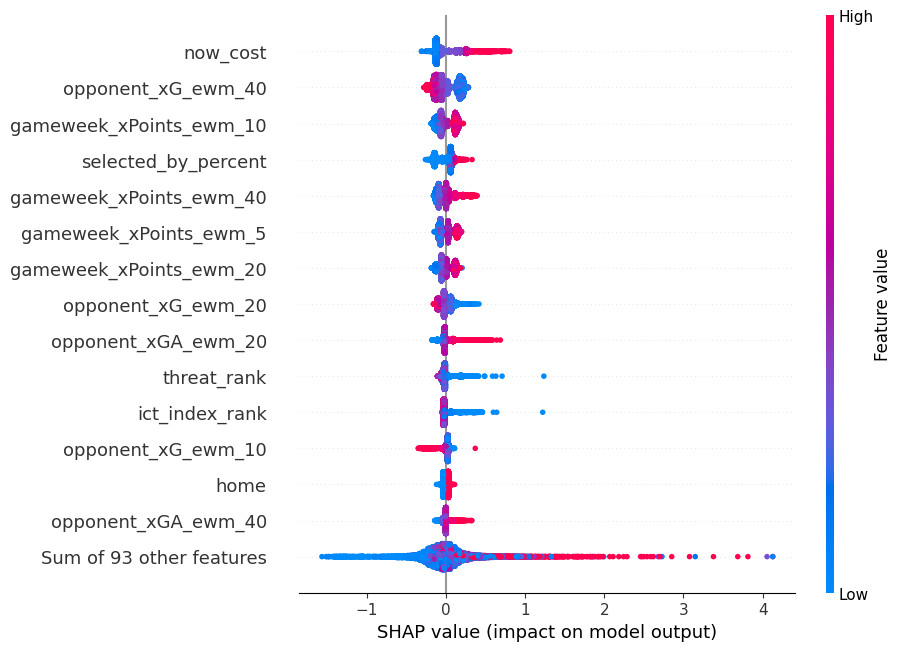


OPTIMIZATION TRIALS DATA


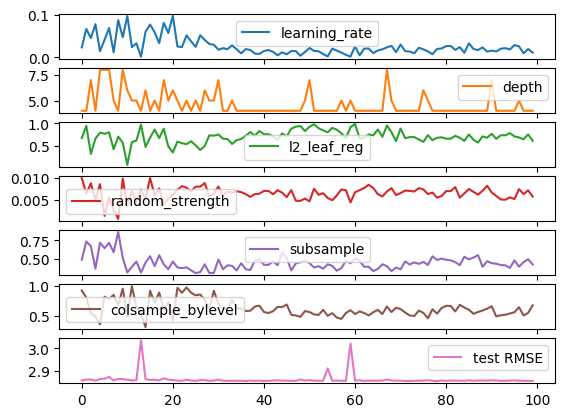

BEST PARAMETERS TEST SCORES


MAE      RMSE        r2
test  2.100264  2.838187  0.066357

In [27]:
# OPTIMIZATION
n_trials = 100

folds = KFold(n_splits=4, shuffle=False) 
test_metric='RMSE'
model_params = {}
model_params['cat_features'] = ['element_type']

best_params = {}
metrics = {}
metrics, best_params, cat_model, shap_values, study = cat_optuna(X_train, y_train, X_test, y_test, model_params, 
               cat_optuna_params, best_params, metrics, folds, test_metric, n_optimization_trials=n_trials)

print('OPTIMIZATION TRIALS DATA')
test_scores = [study.get_trials()[i].values[0] for i in range(0,len(study.get_trials()))]
params = [pd.DataFrame(study.get_trials()[i].params, index=[i]) for i in range(0,len(study.get_trials()))]
trial_data = pd.concat(params)
trial_data[f'test {test_metric}'] = test_scores

# plot trial data
trial_data.plot(subplots=True)
plt.show()

# save trial data
time_now = dt.datetime.now()
filename = 'catboost_' + str(time_now.strftime("%Y%m%d-%H%M%S")) + '.csv'
filepath = Path('../../data/trial_data/' + filename)
trial_data.to_csv(filepath)

print('BEST PARAMETERS TEST SCORES')
results = pd.DataFrame(np.array([metrics['test']]), index=['test'], columns=('MAE', 'RMSE', 'r2'))
display(results)

In [28]:
# save the catboost model
save_dir = '../../models/'
file_name = 'catboost_' + str(time_now.strftime("%Y%m%d-%H%M%S")) + '.cbm'
file_path = Path(save_dir + file_name)
cat_model.save_model(file_path, format="cbm",)

### Check trial runs

In [ ]:
trials = []
folder_path_str = '../../data/trial_data'
folderpath = Path(folder_path_str)
for file in os.listdir(folderpath):
    df = pd.read_csv(Path(folder_path_str + '/' + file), index_col=0)
    trials.append(df)
len(trials)

In [ ]:
best_rmse = []
for i in range(len(trials)):
    df = trials[i]
    best_rmse.append(df['test RMSE'].min())
best_rmse

In [ ]:
min(best_rmse)

In [ ]:
os.listdir(folderpath)[best_rmse.index(min(best_rmse))]

In [ ]:
df = pd.read_csv(Path(folder_path_str + '/' + 'catboost_20230806-102207.csv'), index_col=0)
display(df['test RMSE'].min())
display(df.columns)
display(df)

### Load model and look a bit more closely

In [ ]:
# load model
cat_model = catboost.CatBoostRegressor()
cat_model.load_model('../../models/catboost_20230806-222305.cbm')

In [ ]:
# test predictions
y_predicted = pd.Series(
    cat_model.predict(X_test),
    index=X_test.index
)

print('CATBOOST')
metrics["test"] = calculate_performance_metrics(y_test.values.flatten(), y_predicted.values.flatten())
results = pd.DataFrame(np.array([metrics['test']]), index=['test'], columns=('MAE', 'RMSE', 'r2'))
display(results)

In [ ]:
explainer = shap.Explainer(cat_model)

In [ ]:
shap_values = explainer(X_train);
shap.plots.beeswarm(shap_values, max_display=20)

# LOAD MODEL AND TRAIN WITH ALL OF THE DATA 

In [36]:
# load prediction model
model = catboost.CatBoostRegressor()
path = Path('../../models/catboost_20230809-201635.cbm')
model.load_model(path)

In [40]:
my_params = model.get_params()
display(my_params)

{'rsm': 0.6775112397,
 'random_strength': 0.005676433533,
 'eval_metric': 'RMSE',
 'verbose': 0,
 'iterations': 368,
 'l2_leaf_reg': 0.6135726102,
 'loss_function': 'RMSE',
 'subsample': 0.4199749124,
 'depth': 4,
 'learning_rate': 0.01927870832}

In [41]:
# fit final model using all of the data
model = catboost.CatBoostRegressor(**my_params)
model.fit(X, y)

In [43]:
# save the model
save_dir = '../../models/'
time_now = dt.datetime.now()
file_name = 'catboost_' + str(time_now.strftime("%Y%m%d-%H%M%S")) + '.cbm'
file_path = Path(save_dir + file_name)
model.save_model(file_path, format="cbm",)